# Objective
Identify and rank the most significant factors (features) associated with the target variable, MHLTH_CrudePrev.

# Approach:
We will focus on:

1. Building robust Random Forest and XGBoost models.
2. Using feature importance metrics and interpretation tools like SHAP to rank the significance of each feature.

In [1]:
import pandas as pd

# URL of the raw CSV file in your GitHub repository
url = "https://raw.githubusercontent.com/SodiumMan91/mental-health-prediction/refs/heads/main/data/data.csv"

df = pd.read_csv(url)
df = df.drop(['Unnamed: 0.1', 'Unnamed: 0', 'lon', 'lat', 'nearest_lat', 'nearest_lon'], axis = 1)

In [2]:
df.head()

,StateAbbr,StateDesc,CountyName,CountyFIPS,TractFIPS,TotalPopulation,TotalPop18plus,ACCESS2_CrudePrev,ARTHRITIS_CrudePrev,BINGE_CrudePrev,...,D3APO,D4A,D4C,D4D,D5AR,D5AE,D5BR,D5BE,D5CR,D5CRI
0,NY,New York,Albany,36001,36001000100,2073,1507,12.2,28.7,15.5,...,0.081900,0.990340,0.990502,0.608667,0.052916,0.044596,0.027136,0.053216,0.049366,0.799864
1,NY,New York,Albany,36001,36001000201,3125,2314,10.9,24.9,17.0,...,0.128381,0.781805,0.781949,0.481601,0.041881,0.041040,0.022724,0.047323,0.042171,0.649692
2,NY,New York,Albany,36001,36001000202,2598,1756,10.8,26.7,15.5,...,0.043570,0.396692,0.396177,0.243470,0.020306,0.017547,0.009811,0.018994,0.018944,0.306940
3,NY,New York,Albany,36001,36001000301,3190,2189,11.1,26.6,16.8,...,0.105913,0.997369,0.990393,0.608603,0.046016,0.040432,0.016988,0.039075,0.042929,0.695568
4,NY,New York,Albany,36001,36001000302,3496,2956,6.3,22.2,20.5,...,0.010392,0.000000,0.000000,0.000000,0.001049,0.001796,0.000000,0.000000,0.081016,0.160011


In [3]:
# Check for missing values in the features (X)
missing_values = df.isnull().sum()

# Filter to only show columns with missing values
missing_values = missing_values[missing_values > 0]

# Display the columns with missing values and their counts
print("Columns with Missing Values:")
print(missing_values)

# Optionally, calculate the percentage of missing values for better understanding
missing_percentage = (missing_values / len(df)) * 100
print("\nPercentage of Missing Values:")
print(missing_percentage)


Columns with Missing Values:
COLON_SCREEN_CrudePrev       1
MAMMOUSE_CrudePrev           8
TEETHLOST_CrudePrev          6
STATEFP_y                 1089
COUNTYFP_y                1089
TRACTCE_y                 1089
BLKGRPCE_y                1089
dtype: int64

Percentage of Missing Values:
COLON_SCREEN_CrudePrev     0.018907
MAMMOUSE_CrudePrev         0.151257
TEETHLOST_CrudePrev        0.113443
STATEFP_y                 20.589904
COUNTYFP_y                20.589904
TRACTCE_y                 20.589904
BLKGRPCE_y                20.589904
dtype: float64


In [4]:
# Calculate the percentage of missing values for each column
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Filter columns with more than 5% missing values
columns_to_drop = missing_percentage[missing_percentage > 5].index

# Drop those columns from the DataFrame
df_cleaned = df.drop(columns=columns_to_drop)

print(f"Columns dropped: {list(columns_to_drop)}")
print(f"Shape of DataFrame after dropping columns: {df_cleaned.shape}")

Columns dropped: ['STATEFP_y', 'COUNTYFP_y', 'TRACTCE_y', 'BLKGRPCE_y']
Shape of DataFrame after dropping columns: (5289, 75)


In [5]:
from sklearn.impute import SimpleImputer

# Identify numerical columns with missing values
missing_numerical = df_cleaned.select_dtypes(include=['number']).isnull().sum()
columns_with_missing = missing_numerical[missing_numerical > 0].index

# Create a SimpleImputer for numerical data
imputer = SimpleImputer(strategy='median')  # Use 'mean' if preferred

# Impute only the numerical columns with missing values
df_cleaned[columns_with_missing] = imputer.fit_transform(df_cleaned[columns_with_missing])

print("Missing values after imputation in numerical columns:")
print(df_cleaned[columns_with_missing].isnull().sum())

Missing values after imputation in numerical columns:
COLON_SCREEN_CrudePrev    0
MAMMOUSE_CrudePrev        0
TEETHLOST_CrudePrev       0
dtype: int64


In [6]:
# Identify columns with only one unique value across the entire dataset
columns_to_drop_all = [col for col in df_cleaned.columns if df_cleaned[col].nunique() == 1]

# Drop these columns from the DataFrame
df_cleaned_dropped_all = df_cleaned.drop(columns=columns_to_drop_all)

# Print the dropped columns and the shape of the updated DataFrame
print(f"Columns dropped: {columns_to_drop_all}")
print(f"Shape of DataFrame after dropping columns: {df_cleaned_dropped_all.shape}")

Columns dropped: ['StateAbbr', 'StateDesc', 'STATEFP_x', 'MTFCC', 'FUNCSTAT']
Shape of DataFrame after dropping columns: (5289, 70)


In [7]:
# Define the target variable and features
target = 'MHLTH_CrudePrev'  # Replace with the exact target variable name if needed
y = df_cleaned_dropped_all[target]  # Target variable
X = df_cleaned_dropped_all.drop(columns=[target])  # All other columns as features

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (5289, 69)
Shape of y: (5289,)


In [8]:
# Separate categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

print("Categorical Columns:", categorical_cols)
print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
print("Numerical Columns:", numerical_cols)

Categorical Columns: ['CountyName', 'Geolocation', 'GEOIDFQ', 'NAMELSAD']
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Numerical Columns: ['CountyFIPS', 'TractFIPS', 'TotalPopulation', 'TotalPop18plus', 'ACCESS2_CrudePrev', 'ARTHRITIS_CrudePrev', 'BINGE_CrudePrev', 'CANCER_CrudePrev', 'CASTHMA_CrudePrev', 'CHD_CrudePrev', 'CHECKUP_CrudePrev', 'COLON_SCREEN_CrudePrev', 'COPD_CrudePrev', 'CSMOKING_CrudePrev', 'DENTAL_CrudePrev', 'DEPRESSION_CrudePrev', 'DIABETES_CrudePrev', 'GHLTH_CrudePrev', 'LPA_CrudePrev', 'MAMMOUSE_CrudePrev', 'OBESITY_CrudePrev', 'PHLTH_CrudePrev', 'SLEEP_CrudePrev', 'STROKE_CrudePrev', 'TEETHLOST_CrudePrev', 'HEARING_CrudePrev', 'VISION_CrudePrev', 'COGNITION_CrudePrev', 'MOBILITY_CrudePrev\t', 'SELFCARE_CrudePrev', 'INDEPLIVE_CrudePrev', 'DISABILITY_CrudePrev', 'nearest_index', 'distance_km', 'index_right', 'COUNTYFP_x', 'TRACTCE_x', 'BLKGRPCE_x', 'GEOID', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'P_WrkAge', 'Pct_AO1', 'Pct_A

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Create a OneHotEncoder for the categorical columns (using the correct argument)
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform the categorical columns
X_encoded = encoder.fit_transform(X[categorical_cols])

# Convert the encoded categorical columns into a DataFrame with proper column names
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Combine the encoded categorical columns with the numerical columns from X
X_final = pd.concat([X[numerical_cols], X_encoded_df], axis=1)

# Print the final DataFrame shape and sample to ensure correctness
print(f"Shape of the final dataset: {X_final.shape}")
print(X_final.head())

Shape of the final dataset: (5289, 10714)
   CountyFIPS    TractFIPS  TotalPopulation  TotalPop18plus  \
0       36001  36001000100             2073            1507   
1       36001  36001000201             3125            2314   
2       36001  36001000202             2598            1756   
3       36001  36001000301             3190            2189   
4       36001  36001000302             3496            2956   

   ACCESS2_CrudePrev  ARTHRITIS_CrudePrev  BINGE_CrudePrev  CANCER_CrudePrev  \
0               12.2                 28.7             15.5               5.2   
1               10.9                 24.9             17.0               4.8   
2               10.8                 26.7             15.5               4.2   
3               11.1                 26.6             16.8               4.9   
4                6.3                 22.2             20.5               6.8   

   CASTHMA_CrudePrev  CHD_CrudePrev  ...  GEOIDFQ_1500000US361231505021  \
0               13.9   

In [10]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the entire dataset (both numerical and encoded categorical columns)
X_standardized = scaler.fit_transform(X_final)

# Convert the standardized numpy array back to a pandas DataFrame
X_standardized_df = pd.DataFrame(X_standardized, columns=X_final.columns)

# Print the final standardized DataFrame's shape and a preview
print(f"Shape of the standardized dataset: {X_standardized_df.shape}")
print(X_standardized_df.head())

Shape of the standardized dataset: (5289, 10714)
   CountyFIPS  TractFIPS  TotalPopulation  TotalPop18plus  ACCESS2_CrudePrev  \
0   -1.928833  -1.931851        -1.032756       -1.109321           0.748217   
1   -1.928833  -1.931847        -0.410612       -0.525995           0.482864   
2   -1.928833  -1.931847        -0.722275       -0.929336           0.462452   
3   -1.928833  -1.931844        -0.372171       -0.616349           0.523687   
4   -1.928833  -1.931844        -0.191205       -0.061937          -0.456080   

   ARTHRITIS_CrudePrev  BINGE_CrudePrev  CANCER_CrudePrev  CASTHMA_CrudePrev  \
0             0.746185        -0.650132         -0.826447           2.272187   
1             0.079478        -0.190842         -0.983322           1.402418   
2             0.395286        -0.650132         -1.218634           2.539808   
3             0.377742        -0.252081         -0.944103           1.937661   
4            -0.394235         0.880833         -0.198948          -0.

Training Random Forest model...
Random Forest model training complete.
Training XGBoost model...
XGBoost model training complete.
Calculating SHAP values for Random Forest...
SHAP values for Random Forest calculated.
Calculating SHAP values for XGBoost...
SHAP values for XGBoost calculated.
Generating SHAP summary plot for Random Forest...


C:\Users\naman\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:950: UserWarning: Glyph 9 (	) missing from current font.
  pl.tight_layout()
C:\Users\naman\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


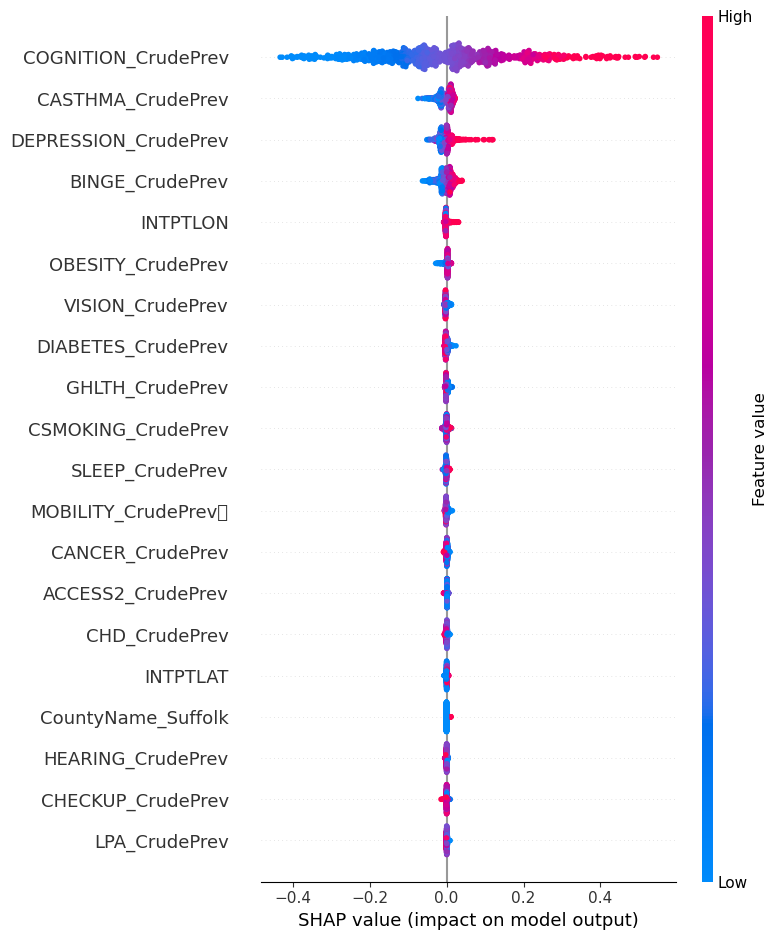

Generating SHAP summary plot for XGBoost...


C:\Users\naman\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:950: UserWarning: Glyph 9 (	) missing from current font.
  pl.tight_layout()
C:\Users\naman\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


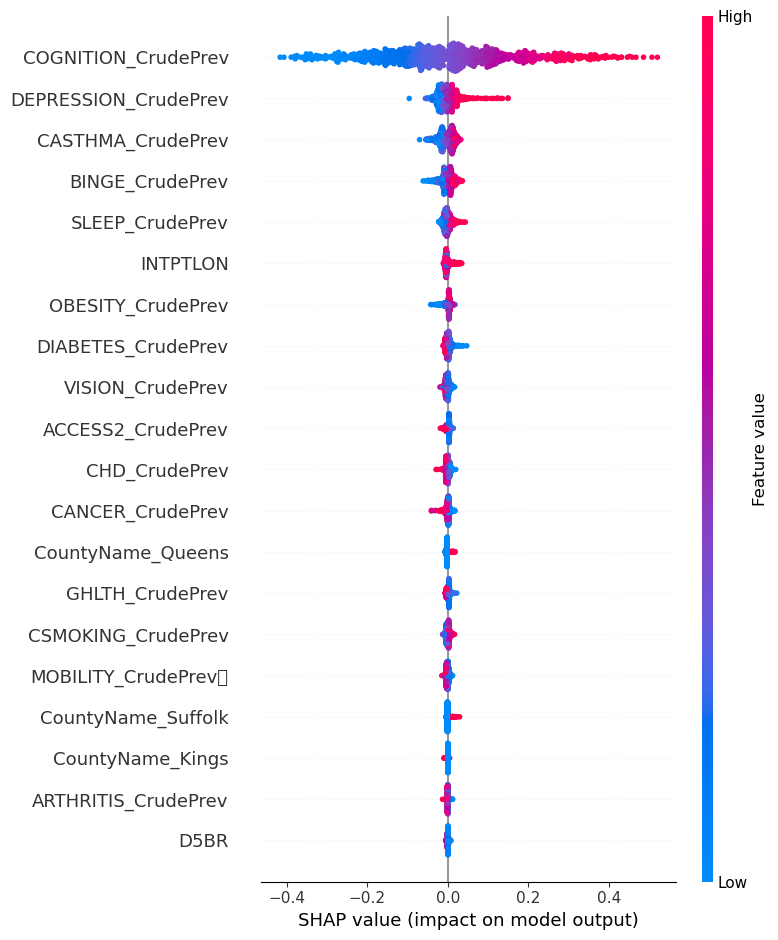

Random Forest Feature Importances:  [9.11956740e-05 3.22599970e-04 3.59803498e-04 ... 2.61028011e-07
 0.00000000e+00 4.48926555e-08]
XGBoost Feature Importances:  [0.00028423 0.00067544 0.00122688 ... 0.         0.         0.        ]


In [11]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import shap

# Train-test split (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_standardized_df, y, test_size=0.2, random_state=42)

# Create and train Random Forest model
print("Training Random Forest model...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)  # Random Forest does not have a verbosity parameter

# Feature Importance from Random Forest
rf_feature_importance = rf_model.feature_importances_
print("Random Forest model training complete.")

# Create and train XGBoost model
print("Training XGBoost model...")
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=1)
xgb_model.fit(X_train, y_train)

# Feature Importance from XGBoost
xgb_feature_importance = xgb_model.feature_importances_
print("XGBoost model training complete.")

# SHAP Values for Random Forest
print("Calculating SHAP values for Random Forest...")
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)
print("SHAP values for Random Forest calculated.")

# SHAP Values for XGBoost
print("Calculating SHAP values for XGBoost...")
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test)
print("SHAP values for XGBoost calculated.")

# Plot SHAP values for interpretation
print("Generating SHAP summary plot for Random Forest...")
shap.summary_plot(shap_values_rf, X_test)

print("Generating SHAP summary plot for XGBoost...")
shap.summary_plot(shap_values_xgb, X_test)

# Print Feature Importances
print("Random Forest Feature Importances: ", rf_feature_importance)
print("XGBoost Feature Importances: ", xgb_feature_importance)

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict on the test set
rf_predictions = rf_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)

# Calculate metrics for Random Forest
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

# Calculate metrics for XGBoost
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

# Print metrics
print("Random Forest Metrics:")
print(f"Mean Squared Error (MSE): {rf_mse}")
print(f"Mean Absolute Error (MAE): {rf_mae}")
print(f"R-squared (R²): {rf_r2}")

print("\nXGBoost Metrics:")
print(f"Mean Squared Error (MSE): {xgb_mse}")
print(f"Mean Absolute Error (MAE): {xgb_mae}")
print(f"R-squared (R²): {xgb_r2}")


Random Forest Metrics:
Mean Squared Error (MSE): 0.0006905577766881502
Mean Absolute Error (MAE): 0.01917202659334504
R-squared (R²): 0.9816893911768959

XGBoost Metrics:
Mean Squared Error (MSE): 0.0005392411219648661
Mean Absolute Error (MAE): 0.016260136648072406
R-squared (R²): 0.9857016551272735


In [13]:
# Create a DataFrame to compare feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # Use X_train.columns to get feature names
    'RandomForest Importance': rf_feature_importance,
    'XGBoost Importance': xgb_feature_importance
})

# Sort the dataframe by the RandomForest importance (you can change this to sort by XGBoost as well)
feature_importance_df = feature_importance_df.sort_values(by='RandomForest Importance', ascending=False)

# Display the top features for comparison
print("Feature Importance Comparison:")
print(feature_importance_df.head(10))  # Show top 10 features


Feature Importance Comparison:
                 Feature  RandomForest Importance  XGBoost Importance
27   COGNITION_CrudePrev                 0.872330            0.708337
15  DEPRESSION_CrudePrev                 0.025097            0.023940
8      CASTHMA_CrudePrev                 0.019884            0.028190
6        BINGE_CrudePrev                 0.019215            0.027364
20     OBESITY_CrudePrev                 0.005133            0.011873
13    CSMOKING_CrudePrev                 0.005112            0.006381
16    DIABETES_CrudePrev                 0.004166            0.011378
26      VISION_CrudePrev                 0.003586            0.014571
42              INTPTLON                 0.003509            0.005512
22       SLEEP_CrudePrev                 0.002894            0.005299


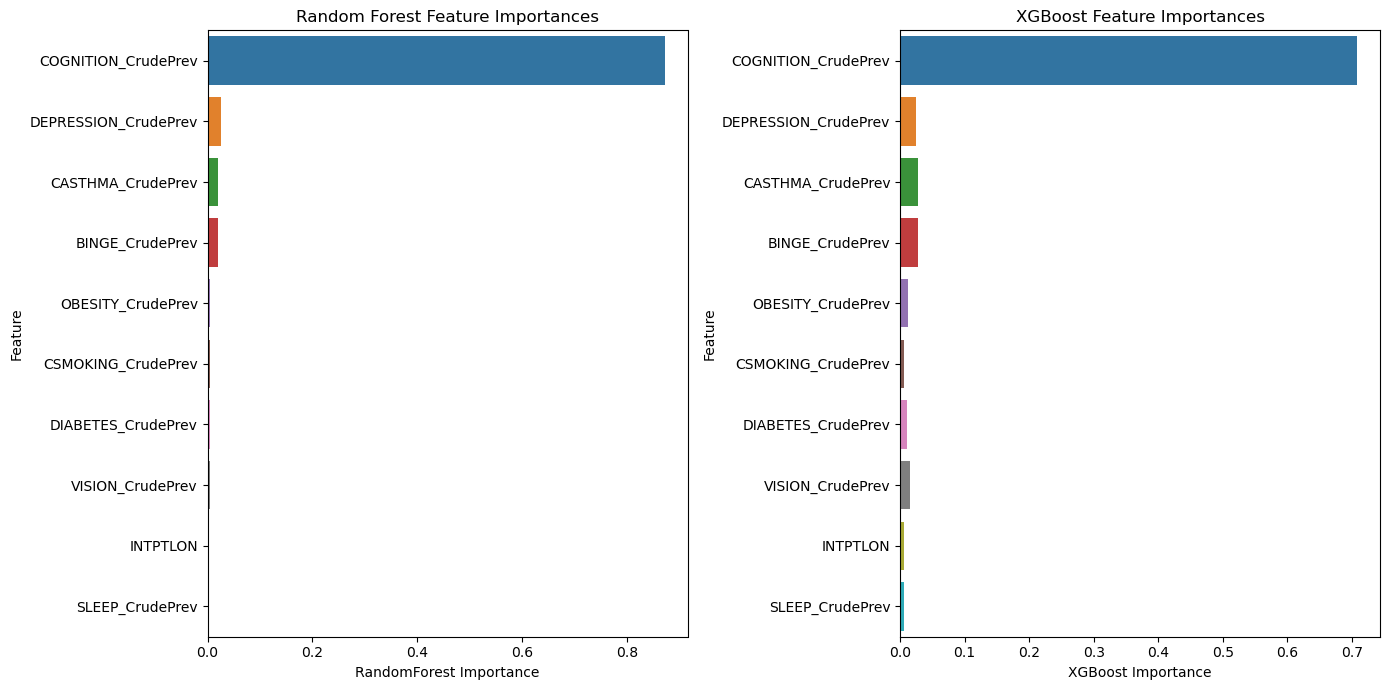

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot feature importances from RandomForest and XGBoost
plt.figure(figsize=(14, 7))

# Random Forest plot
plt.subplot(1, 2, 1)
sns.barplot(x='RandomForest Importance', y='Feature', data=feature_importance_df.head(10))  # Top 10 features
plt.title('Random Forest Feature Importances')

# XGBoost plot
plt.subplot(1, 2, 2)
sns.barplot(x='XGBoost Importance', y='Feature', data=feature_importance_df.head(10))  # Top 10 features
plt.title('XGBoost Feature Importances')

plt.tight_layout()
plt.show()
